# Asymptotic normality - one dimension examples

## Two-armed bandit  and AR(1) model

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import scipy

## Two-armed bandit with $\epsilon$-Greedy algorithm

In [2]:
# define reward function
def reward():
    # true signal 0.3
    return  0.3 + np.random.poisson(1,1)[0] - 1


# define function for generating predictable weights w_t
def f(x):
    return 1/np.sqrt(x*np.log(np.exp(2)*x)*np.log(np.log(np.exp(2)*x))**2)


# define eps Greedy algorithm
def ECB(n):
    rewards_seq = np.array([reward() for i in range(n)])
    x = [0, 1]
    y = [rewards_seq[0], rewards_seq[1]]
    nums = np.array([1 , 1 ])
    rewards = np.array(y)
    
    for i in range(n-2):
        # compute arm means
        arm_means = rewards/nums
        arm = np.argmax(arm_means)
        flag = np.random.uniform(0,1,1)[0]
        # defining decaying rate
        if flag > 1 - np.log(i+1)**0.5/np.sqrt(i+1) and i>50:
            arm = 1 - arm
        x.append(arm)
        newr = rewards_seq[i+2]
        y.append(newr)
        nums[arm] += 1
        rewards[arm] += newr
    # return the noise sequence
    return x, y, rewards_seq - 0.3

# Generate the histogram of the fraction of the number of first arm pulled to the total number of runs
def ECB_hist():
    n = 1000
    rewards_seq = np.array([reward() for i in range(n)])
    x = [0, 1]
    y = [rewards_seq[0], rewards_seq[1]]
    nums = np.array([1 , 1 ])
    rewards = np.array(y)
    for i in range(n-2):
        arm_means = rewards/nums
        arm = np.argmax(arm_means)
        flag = np.random.uniform(0,1,1)[0]
        if flag > 1 - np.log(i+1)**0.5/np.sqrt(i+1) and i>50:
            arm = 1 - arm
        x.append(arm)
        newr = rewards_seq[i+2]
        y.append(newr)
        nums[arm] += 1
        rewards[arm] += newr
    return np.sum(np.array(x))

### Histogram of $\frac{S_{11}}{n}$

(array([236., 135.,  64.,  49.,  27.,  39.,  36.,  63., 155., 196.]),
 array([ 94., 176., 258., 340., 422., 504., 586., 668., 750., 832., 914.]),
 <BarContainer object of 10 artists>)

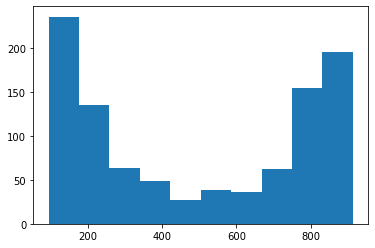

In [3]:
p = []
for i in range(1000):
    p.append(ECB_hist())
plt.hist(np.array(p))

In [4]:
# define erros
def scaled_estimators(n,sampler):
    x,y,noise = sampler(n)
    X = np.zeros((n,2))
    # construct X
    X[:,0] = (np.array(x) == 0) - 0
    X[:,1] = (np.array(x) == 1) - 0
    # y
    y = np.array(y)
    
    # compute OLS
    M = LinearRegression( fit_intercept = False).fit(X, y)
    coeff = M.coef_
    coeff = coeff[0]
    Sn = X.T@X
    Sn = Sn[0,0]
    
    # standardize errors for ols
    ols = np.sqrt(Sn)*(coeff - 0.3)
    
    # extract information for the first arm
    ysub = y[np.array(x) == 0]
    noise_sub = noise[np.array(x) == 0]
    n1 = len(ysub)
    
    # define s0
    s0 = np.exp(2)*np.log(n)
    w = []
    
    # compute weights w
    # consider self-scaled version
    for i in range(n1):
        w.append(f(1 + (i+1)/s0)/np.sqrt(s0))
    w = np.array(w)
    
    # equivalent form for standardized residual
    # factor 1/np.sqrt(np.sum(w**2)) is used to stablize the variance
    alee = 1/np.sqrt(np.sum(w**2))*np.sum(w*noise_sub)
    
    return np.array([ols, alee]).reshape(1,2)
    
#   replication function
def scaled_repli(N , n,  sampler):
    E = np.zeros((N,2))
    for i in range(N):
        E[i,:] = scaled_estimators(n,sampler)
    return E

In [5]:
np.random.seed(666)
# 3000 replications with n = 1000
E = scaled_repli(3000, 1000, ECB)

/Users/mufangying/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


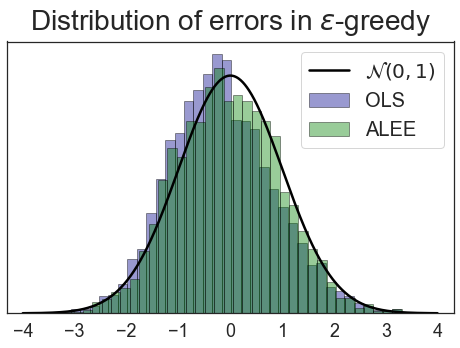

In [6]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
#sns.histplot(E[:,0], label = 'OLS', stat = 'density', kde = True, line_kws = {'lw': 5.5} , lw = 1.5)
sns.distplot(E[:,0],  norm_hist=True,  kde=False, label="OLS",   bins=int(180/5), color = 'darkblue', \
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3})
sns.distplot(E[:,1], norm_hist=True,  kde=False, label="ALEE", bins=int(180/5), color = 'green', \
             hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 3})
plt.plot(np.arange(-4, 4, 0.01), norm.pdf(np.arange(-4, 4, 0.01), 0, 1), \
         label = r'$\mathcal{N}(0,1)$', c = "black", lw=2.5)
plt.ylabel('')

plt.legend(prop={'size': 20})
plt.yticks([], [])
plt.xticks(fontsize = 18)
plt.xlim(-4.3,4.3)
plt.title(r'Distribution of errors in $\epsilon$-greedy', fontsize = 28, y = 1.02)
plt.savefig('Bandit-ECB-OLS-ALEE-poisson.pdf')

## AR(1) model

In [7]:
# generate data
def AR(n):
    x = np.zeros(n)
    y = np.zeros(n)
    noise_seq = np.random.poisson(1,n) - 1
    for i in range(n):
        y[i] = x[i] + noise_seq[i]
        if i < n -1:
            x[i+1] = y[i]
    return x,y,noise_seq

def AR_scaled_estimators(n):
    x,y,noise_seq = AR(n)
    X = x.reshape(-1,1)

    # compute OLS
    M = LinearRegression( fit_intercept = False).fit(X, y)
    coeff = M.coef_
    coeff = coeff[0]
    Sn = X.T@X
    Sn = Sn[0,0]
   
    ols = np.sqrt(Sn)*(coeff - 1)
    
    s0 = np.exp(2)*n/np.log(np.log(n))
    w = []
    
    # consider f2 to compute weights w
    for i in range(n):
        w.append(f(1 + np.sum(x[:(i+1),]**2)/s0)*x[i]/np.sqrt(s0))
    w = np.array(w)

    # scale the variance
    alee = 1/np.sqrt(np.sum(w**2))*np.sum(w*noise_seq)
    
    return np.array([ols, alee]).reshape(1,2)
    

def AR_repli(N , n):
    E = np.zeros((N,2))
    for i in range(N):
        E[i,:] = AR_scaled_estimators(n)
    return E

### Replications

In [8]:
np.random.seed(666)
E1 = AR_repli(3000, 1000)

/Users/mufangying/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


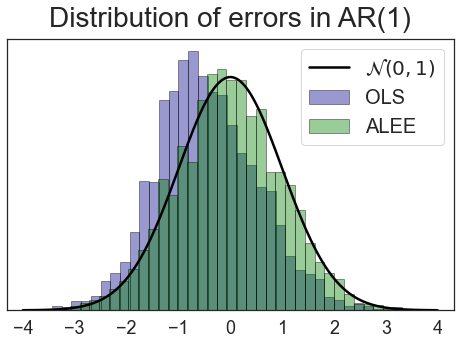

In [9]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
sns.distplot(E1[:,0],  norm_hist=True,  kde=False, label="OLS",   bins=int(180/5), color = 'darkblue', \
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3})
sns.distplot(E1[:,1], norm_hist=True,  kde=False, label="ALEE", bins=int(180/5), color = 'green', \
             hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 3})
plt.plot(np.arange(-4, 4, 0.01), norm.pdf(np.arange(-4, 4, 0.01), 0, 1), label = r'$\mathcal{N}(0,1)$', c = "black", lw=2.5)
plt.ylabel('')

plt.legend(prop={'size': 20})
plt.yticks([], [])
plt.xticks(fontsize = 18)
plt.xlim(-4.3,4.3)
plt.title('Distribution of errors in AR(1)', fontsize = 28, y = 1.02)
plt.savefig('AR1-OLS-ALEE-poisson.pdf')